In [44]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import curve_fit

In [2]:
# filepath = sys.argv[1]
stim_type = 'smooth'
# param = sys.argv[3]
# val = sys.argv[4]
# par = f'{param}_{val}'


net = f'fb_thesis_linear'

# load dataframe 
response_data = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/responses_RG_mu.csv')


# load dataframe 
df = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/anticipation_data_mu.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['mu2'] = df['wTOT']* (df['tauTOT']**2)
df['mu2norm'] = (df['mu2']-df['mu2'].mean())/df['mu2'].std()
df['mu2r'] = df['mu2'].round()
df['tauTOT'] = 1/df['tauB'] - 1/df['tauA']
df['tauTOT'] = df['tauTOT'].round()

df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

mus = df['mu'].unique()
mus2 = df['mu2'].unique()




Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG',
       'onset_RG_pooling', 'onset_RB_pooling'],
      dtype='object')


In [39]:
#df['wBA'].unique()

array([46.])

In [14]:
speeds

array([0.2 , 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.8 ])

In [3]:
with open(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/params_grid_mu', 'rb') as handle:
    params = pickle.load(handle)
params.keys()    

dict_keys(['nb_cells', 'nb_GC_cells', 'saving_range', 'rf_BC', 'rf_BC_s', 'rf_GC', 'rf_GC_s', 'std_GC', 'std_GC_s', 'spacing', 'dt', 'speed', 'bar_width', 'stimulus_polarity', 'start_cell', 'start_tp', 'occluder_width', 'stop_pos', 'w_BC', 'w_GC', 'X0', 'tauA', 'tauA2', 'tauB', 'tauG', 'tauOPL', 'tauOPL2', 'SF', 'input_scale', 'wAB', 'wBA', 'wA2B', 'wA2A', 'wAA2', 'wBA2', 'wGB', 'wGA', 'wGA2', 'd', 'rectification_BC', 'slope_BC', 'threshold_BC', 'rectification_AC', 'slope_GC', 'threshold_GC', 'rectification_n', 'slope_n', 'threshold_n', 'plastic_to_G', 'plastic_to_A', 'krecB', 'krelB', 'betaB', 'krecA', 'krelA', 'betaA', 'krecA2', 'krelA2', 'betaA2', 'tauActB', 'hB', 'tauActA', 'hA', 'tauActG', 'hG', 'distance', 'duration', 'rf_overlap', 'cell_spacing', 'tps', 'std', 'roh', 'pos_rf_mid', 'tps_rf_mid', 'lam', 'tau_res', 'P', 'resonance_freq', 'pos_rf_GC_mid', 'tps_rf_GC_mid', 'ant_time', 'ant_space'])

# Sanity check: Plot responses

1500 0.1
7.524916943521594
1500 0.1
7.524916943521594
300 0.5
1.504983388704319
300 0.5
1.504983388704319
150 1.0
0.7524916943521595
150 1.0
0.7524916943521595
75 2.0
0.3762458471760797
75 2.0
0.3762458471760797


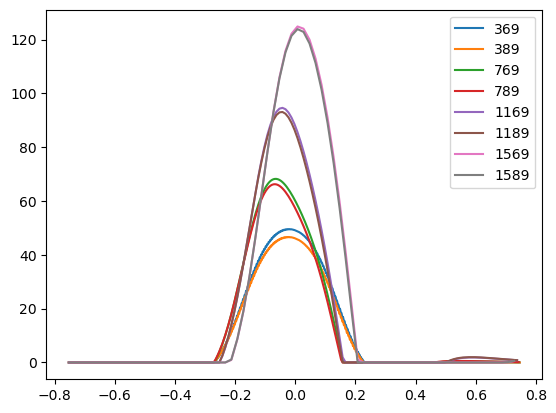

In [4]:
dl = df[df['wTOT'] == -2225.0]
#dl = df[df['wTOT'] == -101.0]
# dl = dl[dl['speed'] == 1.0 ]
dl = dl[dl['tauTOT'] == 122.0 ]
idx = dl['ant_RG_bar_space'].index
len(idx)


for x,i in enumerate(idx):


    r = response_data[f'{i}'].dropna()
    tps = len(r)
    speed = dl['speed'][dl.index[x]]
    print(tps,speed)
    tpm = dl['tp_rf_GC_mid'][dl.index[x]]
    print(tpm)
    time = (np.arange(0,tps)*0.01 -tpm)*speed
    plt.plot(time,r,label = f'{i}')
plt.legend()

In [5]:
var = 'ant_RG_bar_space'

In [6]:

var2 = 'mu2r'
cNorm = colors.Normalize(vmin =df[var2].min(), vmax = df[var2].max())
cmap = plt.get_cmap('viridis', len(df[var2].unique()))

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)




var2 = 'mu2r'
cNorm = colors.Normalize(vmin =0, vmax =  len(df[var2].unique()))
cmap = plt.get_cmap('viridis', len(df[var2].unique()))

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)



# Plot speedscaling for all mu

/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_48198/1370781294.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_48198/1370781294.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  diffsdf = diffsdf._append(data, ignore_index = True)
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_48198/1370781294.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to sile

-60261775.0
diff                                               0.015067
mu                                              -60261775.0
wTOT                                                -4646.0
tauTOT                                                114.0
tauA      119     0.09
519     0.09
919     0.09
1319   ...
wBA       119     46.0
519     46.0
919     46.0
1319   ...
Name: 33, dtype: object
-61712472.0
Unnamed: 0            7.970000e+02
wTOT                 -4.162000e+03
tauTOT                1.220000e+02
wBA                   4.600000e+01
wAB                   9.047000e+01
tauA                  3.100000e-01
tauB                  8.000000e-03
mu                    6.171247e+07
speed                 5.000000e-01
peak_RG               1.361000e+00
peak_RB               1.289000e+00
peak_drive            1.592000e+00
tp_rf_GC_mid          1.504983e+00
peak_RG_pooling       1.596000e+00
peak_RB_pooling       1.601000e+00
onset_RB              1.123000e+03
onset_RG              9.760000e+

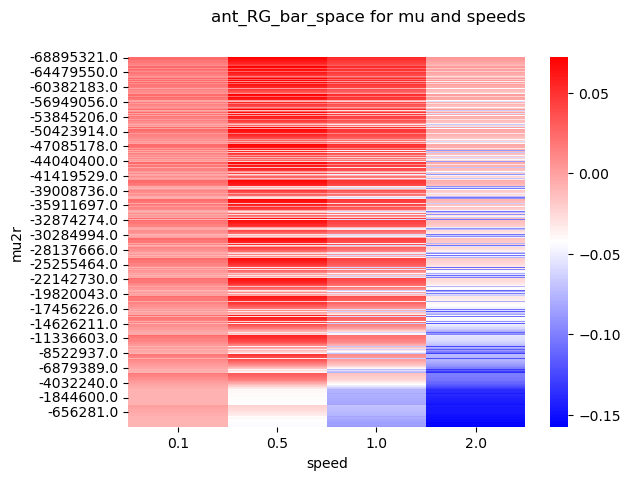

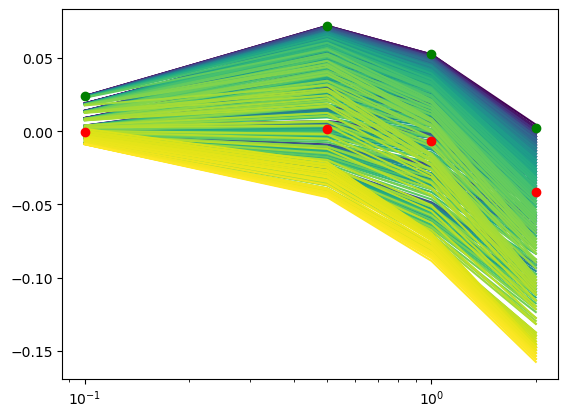

In [7]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'{var} for mu and speeds')


fig2 = plt.figure()
fig2.tight_layout()
#weights = [0.0,10.0,50.0,100.0]

ax = fig.add_subplot(1,1,1)
# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'mu2r',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['mu2r'])
ax = fig2.add_subplot(1,1,1)
ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# get values that yield same anticipation time across speeds

for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    ax.plot(sg['speed'], sg[var], label = f'mu = {w2}',color = scalarMap.to_rgba(x))

    diff = np.mean(np.abs(np.diff(sg[var])))
    data = {'diff': diff,
            'mu' : w2,
            'wTOT': sg['wTOT'].min(),
            'tauTOT': sg['tauTOT'].min(),
            'tauA':sg['tauA'],
            'wBA': sg['wBA']}
    diffsdf = diffsdf._append(data, ignore_index = True)



    # if x == len(subg.groups)-100:
    #     plt.scatter(sg['speed'], sg[var], label = f'mu = {w2}',color = 'r', zorder = len(subg.groups))
    #sg.plot( x = 'speed', y = 'ant_RG_drive_space', label =f'wBA = {w2}', ax = ax)


# get mu for minimal difference between speeds
mi= diffsdf['diff'].argmin()
mimu = diffsdf['mu'][mi]
sg = subg.get_group(mimu)
print(mimu)
print(diffsdf.iloc[mi])
ax.scatter(sg['speed'], sg[var], label = f'mu = {w2}',color = 'r', zorder = len(subg.groups))



#get mu for maximal anticipation
ma = df['ant_RG_bar_space'].argmax()
mamu = df['mu2r'][ma]
sg = subg.get_group(mamu)
print(mamu)
print(df.iloc[ma])
ax.scatter(sg['speed'], sg[var], label = f'mu = {w2}',color = 'g', zorder = len(subg.groups))


#fig2.legend()


# fig3 = plt.figure()
# ax = fig3.add_subplot(111)
# ax.scatter(diffsdf.iloc[mi]['wBA'],diffsdf.iloc[mi]['tauA'])


#fig2.legend()


# plot heatmap w-tau

In [8]:
fontsize_legend = 10
fontsize_labels = 15
fontsize_panellabel = 30
fontsize_ticks = 10
lw = 4
ms = 60

panellabel_position = [-0.08, .85]


figsize_ratio = 3
figsize = (16,12)

save = True
save_name = "Figure 1"
show = True
image_format = "png"
dpi = 300


0.1 -0.008908305647840554 0.024091694352159455
0.5 -0.04500830564784053 0.07199169435215946
1.0 -0.08850830564784051 0.05249169435215939


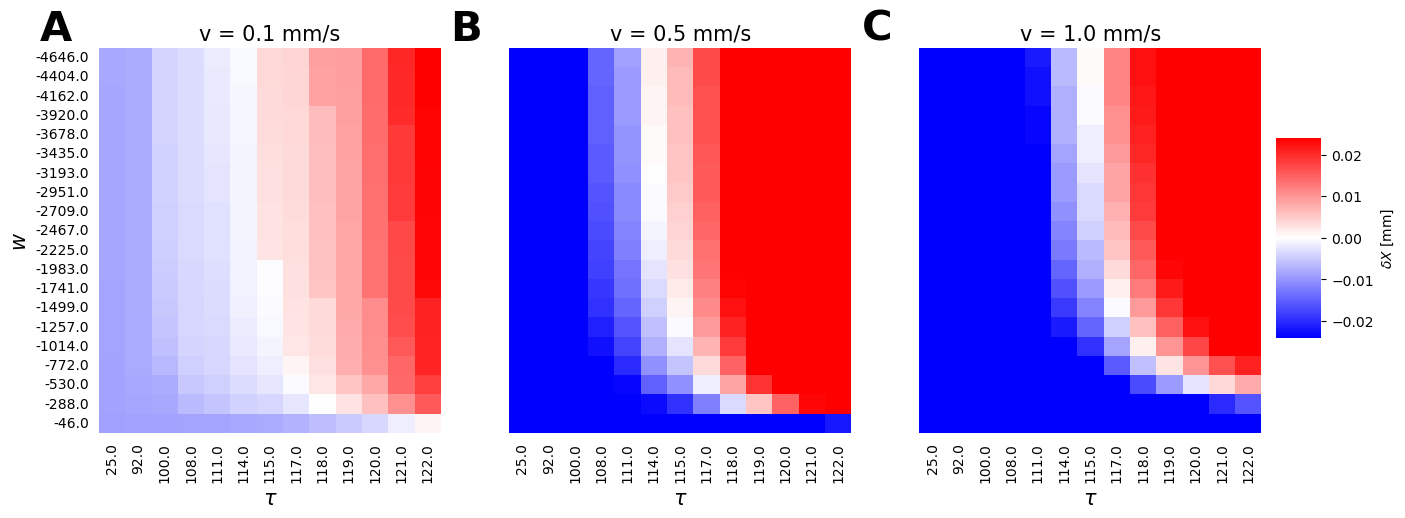

In [9]:

fig = plt.figure(figsize = (15,5))
#fig.suptitle(f'{var}')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

s = 0.1
ax = fig.add_subplot(131)
ax.set_title(f'v = {s} mm/s', fontsize = fontsize_labels)
dfg = df.groupby('speed')
dfs = dfg.get_group(s)
print(s, dfs[var].min(),dfs[var].max())
vmax =  dfs[var].max()
vmin =  -1*dfs[var].max()
# plot heatmap for beta
g_heatmap = dfs.pivot_table(index = 'wTOT',columns = 'tauTOT',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, cmap = 'bwr', ax = ax,  vmin=vmin, vmax=vmax, cbar=None)
ax.tick_params(left=False, bottom=False)
ax.set_ylabel(r'$w$', fontsize = fontsize_labels)
ax.set_xlabel(r'$\tau$', fontsize = fontsize_labels)
ax.tick_params(labelsize = fontsize_ticks)

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

s = 0.5
ax = fig.add_subplot(132)
ax.set_title(f'v = {s} mm/s', fontsize = fontsize_labels)
dfs = dfg.get_group(s)
print(s, dfs[var].min(),dfs[var].max())

# plot heatmap for beta
g_heatmap = dfs.pivot_table(index = 'wTOT',columns = 'tauTOT',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, cmap = 'bwr', ax = ax,   vmin=vmin, vmax=vmax, cbar=None, yticklabels=False)
ax.tick_params(left=False, bottom=False)
ax.set_ylabel('')
ax.set_xlabel(r'$\tau$', fontsize = fontsize_labels)
ax.tick_params(labelsize = fontsize_ticks)
 
ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

s = 1.0
ax = fig.add_subplot(133)
ax.set_title(f'v = {s} mm/s', fontsize = fontsize_labels)
dfs = dfg.get_group(s)
print(s, dfs[var].min(),dfs[var].max())

# plot heatmap for beta
g_heatmap = dfs.pivot_table(index = 'wTOT',columns = 'tauTOT',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, cmap = 'bwr', ax = ax,   vmin=vmin, vmax=vmax, yticklabels=False, cbar_ax=cbar_ax,cbar_kws={'label': r'$\delta X$ [mm]'})
ax.tick_params(left=False, bottom=False)
ax.set_ylabel('')
ax.set_xlabel(r'$\tau$', fontsize = fontsize_labels)   
ax.tick_params(labelsize = fontsize_ticks)

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


fig.savefig('../svg/3B_FB_linear.svg', format='svg')


# plot speedscaling for all wBA

In [68]:

net = f'fb_thesis_linear'

# load dataframe 
response_data = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/responses_RG_wAB_zoom.csv')


# load dataframe 
df = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/anticipation_data_wAB_zoom.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['wAB'].unique



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'wGA'],
      dtype='object')


<bound method Series.unique of 0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
255    21.0
256    21.0
257    21.0
258    21.0
259    21.0
Name: wAB, Length: 260, dtype: float64>

750 0.2
3.762458471760797
653 0.23
3.271703018922432
600 0.25
3.009966777408638
556 0.27
2.787006275378368
500 0.3
2.508305647840531
469 0.32
2.3515365448504983
429 0.35
2.1499762695775986
406 0.37
2.0337613360869176
375 0.4
1.8812292358803984
358 0.42
1.7916468913146657
334 0.45
1.672203765227021
320 0.47
1.601046158196084
300 0.5
1.504983388704319


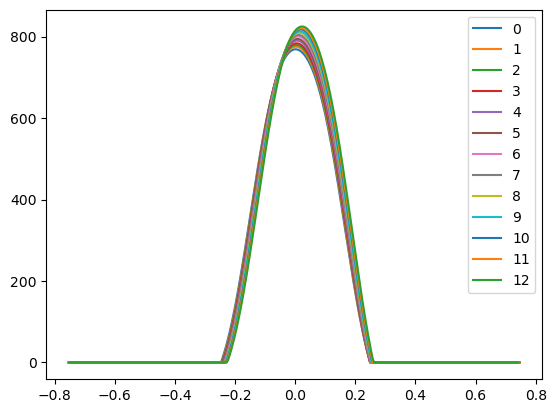

In [69]:
dl = df[df['wAB'] == 1.0]
#dl = df[df['wTOT'] == -101.0]
# dl = dl[dl['speed'] == 1.0 ]
idx = dl['ant_RG_bar_space'].index
len(idx)


for x,i in enumerate(idx):


    r = response_data[f'{i}'].dropna()
    tps = len(r)
    speed = dl['speed'][dl.index[x]]
    print(tps,speed)
    tpm = dl['tp_rf_GC_mid'][dl.index[x]]
    print(tpm)
    time = (np.arange(0,tps)*0.01 -tpm)*speed
    plt.plot(time,r,label = f'{i}')
plt.legend()

/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_48198/886408272.py:28: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


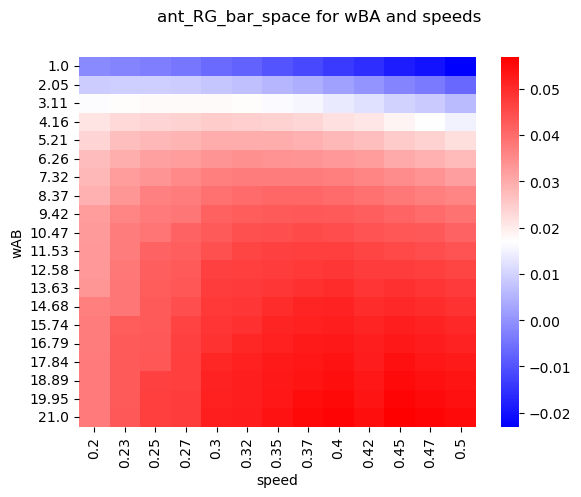

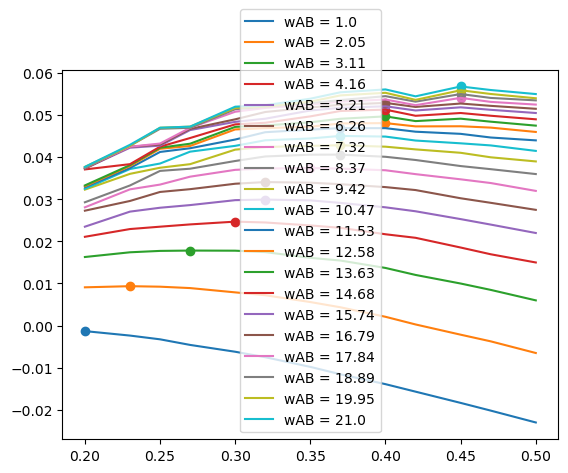

In [70]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'{var} for wBA and speeds')


fig2 = plt.figure()
fig2.tight_layout()
#weights = [0.0,10.0,50.0,100.0]

ax = fig.add_subplot(1,1,1)
# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'wAB',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['wAB'])
ax = fig2.add_subplot(1,1,1)
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])
pref_speeds = []
pref_amp = []
weights = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'wAB = {w2}')#,color = scalarMap.to_rgba(x))
    #ax.plot( sg[var], sg['speed'],label = f'wAB = {w2}')#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi])

    pref_speeds.append(speeds[maxi])
    pref_amp.append(cur[maxi])
    weights.append(w2)
    # diff = np.mean(np.abs(np.diff(sg[var])))
    # data = {'diff': diff,
    #         'mu' : w2,
    #         'wTOT': sg['wTOT'].min(),
    #         'tauTOT': sg['tauTOT'].min(),
    #         'tauA':sg['tauA'],
    #         'wBA': sg['wBA']}
    # diffsdf = diffsdf._append(data, ignore_index = True)

ax.legend()


# get mu for minimal difference between speeds
# mi= diffsdf['diff'].argmin()
# mimu = diffsdf['mu'][mi]
# sg = subg.get_group(mimu)
# print(mimu)
# print(diffsdf.iloc[mi])
# ax.scatter(sg['speed'], sg[var], label = f'mu = {w2}',color = 'r', zorder = len(subg.groups))



# #get mu for maximal anticipation
# ma = df['ant_RG_bar_space'].argmax()
# mamu = df['mu2r'][ma]
# sg = subg.get_group(mamu)
# print(mamu)
# print(df.iloc[ma])
# ax.scatter(sg['speed'], sg[var], label = f'mu = {w2}',color = 'g', zorder = len(subg.groups))
# ax.set_xlabel('anticipation')
# ax.set_ylabel('v')

Text(0, 0.5, '$\\Delta$ A [mm]')

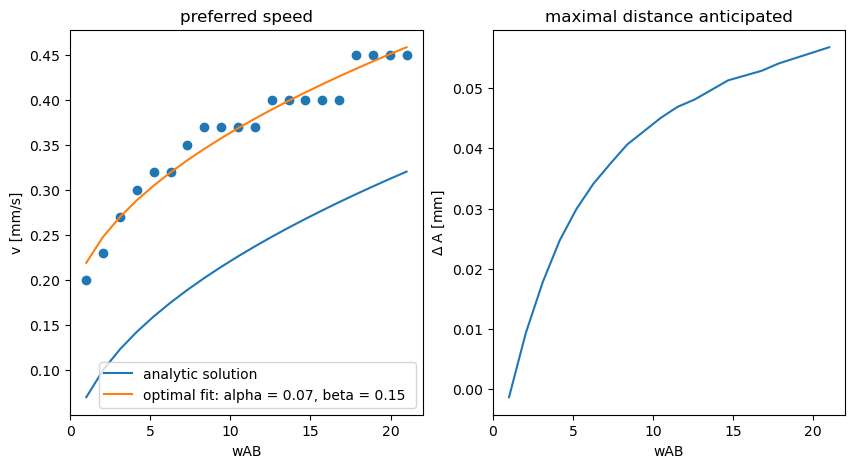

In [92]:
weights = np.asarray(weights)
pref_speeds = np.asarray(pref_speeds)

# def preferred_speed(wplus,wminus,delta):

#     return 2*np.sqrt(wplus*wminus)*delta

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta

popt,_ = curve_fit(preferred_speed,weights,pref_speeds)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('preferred speed')
plt.scatter(weights,pref_speeds)
plt.plot(weights, preferred_speed(weights,0.07,0), label  ='analytic solution')
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)} ')
#plt.plot(weights, preferred_speed(weights,0.07,0.13), label  ='analytic solution + 0.13')

plt.xlabel('wAB')
plt.ylabel('v [mm/s]')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.set_title('maximal distance anticipated')
plt.plot(weights,pref_amp)
plt.xlabel('wAB')
plt.ylabel(r'$\Delta$ A [mm]')

# plot speedscaling for all tauA

In [51]:

net = f'fb_thesis_linear'

# load dataframe 
response_data = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/responses_RG_tauA.csv')


# load dataframe 
df = pd.read_csv(f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/anticipation_data_tauA.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['tauA'].unique()



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'wGA'],
      dtype='object')


array([0.01, 0.04, 0.08, 0.11, 0.14, 0.18, 0.21, 0.24, 0.28, 0.31])

750 0.2
3.762458471760797
500 0.3
2.508305647840531
429 0.35
2.1499762695775986
375 0.4
1.8812292358803984
334 0.45
1.672203765227021
300 0.5
1.504983388704319
273 0.55
1.3681667170039262
250 0.6
1.2541528239202655
231 0.65
1.157679529772553
215 0.7
1.0749881347887993
188 0.8
0.9406146179401992


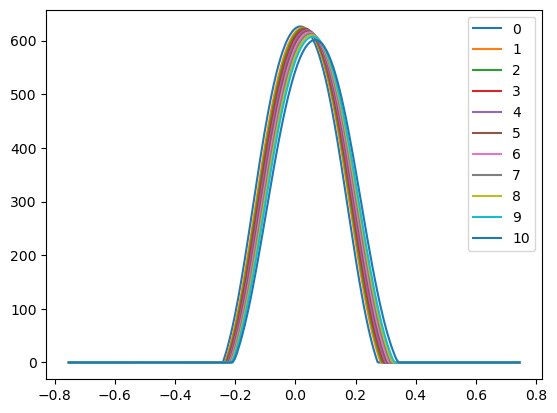

In [53]:
dl = df[df['tauA'] == 0.01]
#dl = df[df['wTOT'] == -101.0]
# dl = dl[dl['speed'] == 1.0 ]
idx = dl['ant_RG_bar_space'].index
len(idx)


for x,i in enumerate(idx):


    r = response_data[f'{i}'].dropna()
    tps = len(r)
    speed = dl['speed'][dl.index[x]]
    print(tps,speed)
    tpm = dl['tp_rf_GC_mid'][dl.index[x]]
    print(tpm)
    time = (np.arange(0,tps)*0.01 -tpm)*speed
    plt.plot(time,r,label = f'{i}')
plt.legend()

/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_18892/4180520914.py:26: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


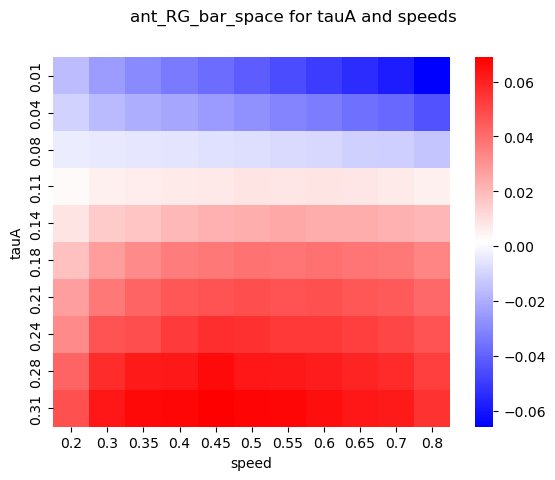

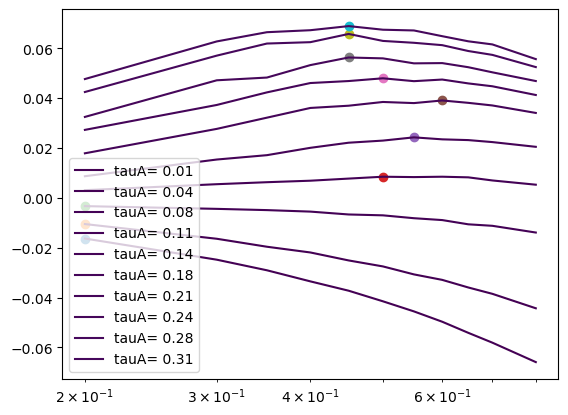

In [54]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'{var} for tauA and speeds')


fig2 = plt.figure()
fig2.tight_layout()
#weights = [0.0,10.0,50.0,100.0]

ax = fig.add_subplot(1,1,1)
# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
ax = fig2.add_subplot(1,1,1)
ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'tauA= {w2}',color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi])
    # diff = np.mean(np.abs(np.diff(sg[var])))
    # data = {'diff': diff,
    #         'mu' : w2,
    #         'wTOT': sg['wTOT'].min(),
    #         'tauTOT': sg['tauTOT'].min(),
    #         'tauA':sg['tauA'],
    #         'wBA': sg['wBA']}
    # diffsdf = diffsdf._append(data, ignore_index = True)

ax.legend()

